In [6]:
import os
import sys
sys.path.append(os.getcwd())

In [28]:
import os
import cv2
import argparse
import glob
import torch
from PIL import Image
from torchvision.transforms.functional import normalize

from basicsr.utils import imwrite, img2tensor, tensor2img
from basicsr.utils.download_util import load_file_from_url
from basicsr.utils.misc import get_device
from basicsr.archs import * # !register architectures
from basicsr.utils.options import dict2str
from basicsr.utils.registry import ARCH_REGISTRY

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = get_device()
# parser = argparse.ArgumentParser()
# parser.add_argument('-i', '--input_image', type=str, default='./inputs/masked_faces/00105.png', 
#                 help='Input image or folder. Default: inputs/masked_faces')
# parser.add_argument('-o', '--output_path', type=str, default='results', 
#                 help='Output folder. Default: results/<input_name>')
# parser.add_argument('--suffix', type=str, default=None, 
#                 help='Suffix of the restored faces. Default: None')
# args = parser.parse_args()

# ------------------------ input & output ------------------------
# print('[NOTE] The input face images should be aligned and cropped to a resolution of 512x512.')
# if args.input_path.endswith(('jpg', 'jpeg', 'png', 'JPG', 'JPEG', 'PNG')): # input single img path
#     input_img_list = [args.input_path]
#     result_root = f'results/test_inpainting_img'
# else: # input img folder
#     if args.input_path.endswith('/'):  # solve when path ends with /
#         args.input_path = args.input_path[:-1]
#     # scan all the jpg and png images
#     input_img_list = sorted(glob.glob(os.path.join(args.input_path, '*.[jpJP][pnPN]*[gG]')))
#     result_root = f'results/{os.path.basename(args.input_path)}'
# test_img_num = len(input_img_list)

suffix = '.jpg'
result_root = 'results'
img_path = '/root/ref/inputs/masked_faces/00108.png'


In [22]:

# ------------------ set up CodeFormer restorer -------------------
net = ARCH_REGISTRY.get('CodeFormer')(dim_embd=512, codebook_size=512, n_head=8, n_layers=9, 
                                        connect_list=['32', '64', '128']).to(device)

# ckpt_path = 'weights/CodeFormer/codeformer.pth'
# pretrain_model_url = 'https://github.com/sczhou/CodeFormer/releases/download/v0.1.0/codeformer_inpainting.pth'
ckpt_path = 'weights/codeformer/codeformer_inpainting.pth'
# ckpt_path = load_file_from_url(
#     url=pretrain_model_url,
#     model_dir='weights/CodeFormer',
#     progress=True, file_name=None
# )
checkpoint = torch.load(ckpt_path)['params_ema']
net.load_state_dict(checkpoint)
net.eval()
# print(net.state_dict().keys())
set([key.split('.')[0] for key in list(net.state_dict().keys())])

{'encoder',
 'feat_emb',
 'ft_layers',
 'fuse_convs_dict',
 'generator',
 'idx_pred_layer',
 'position_emb',
 'quantize'}

Processing: 00108.png


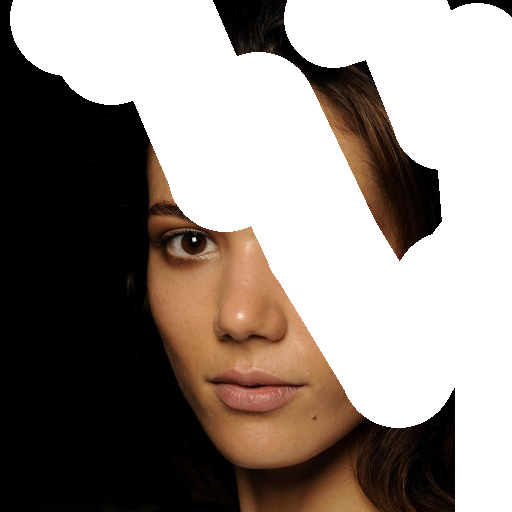

In [33]:
# -------------------- start to processing ---------------------
img_name = os.path.basename(img_path)
basename, ext = os.path.splitext(img_name)
print(f'Processing: {img_name}')
input_face = cv2.imread(img_path)
input_face = cv2.cvtColor(input_face, cv2.COLOR_BGR2RGB)
assert input_face.shape[:2] == (512, 512), 'Input resolution must be 512x512 for inpainting.'
Image.fromarray(input_face)

In [ ]:

# input_face = cv2.resize(input_face, (512, 512), interpolation=cv2.INTER_LINEAR)
input_face = img2tensor(input_face / 255., bgr2rgb=True, float32=True)
normalize(input_face, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
input_face = input_face.unsqueeze(0).to(device)

In [31]:
# try:
with torch.no_grad():
    mask = torch.zeros(512, 512)
    m_ind = torch.sum(input_face[0], dim=0)
    mask[m_ind==3] = 1.0
    mask = mask.view(1, 1, 512, 512).to(device)
    # w is fixed to 1, adain=False for inpainting
    output_face = net(input_face, w=1, adain=False)[0]
    output_face = (1-mask)*input_face + mask*output_face
    save_face = tensor2img(output_face, rgb2bgr=True, min_max=(-1, 1))

del output_face
torch.cuda.empty_cache()
# except Exception as error:
#     print(f'\tFailed inference for CodeFormer: {error}')
#     save_face = tensor2img(input_face, rgb2bgr=True, min_max=(-1, 1))


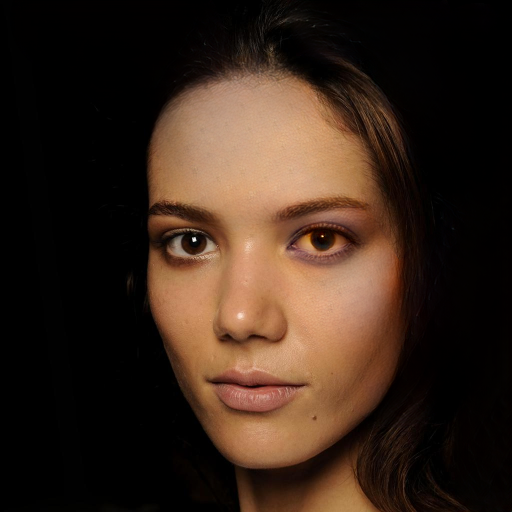

In [32]:
save_face = save_face.astype('uint8')
Image.fromarray(save_face)